In [1]:
import pandas as pd  
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import numpy as np
import plotly.figure_factory as ff
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [2]:
df = pd.read_csv('./DATA/Bank Customer Churn Prediction.csv')
df.head()

,customer_id,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
0,15634602,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,15647311,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,15619304,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,15701354,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,15737888,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [3]:
print("Shape:", df.shape)

Shape: (10000, 12)


In [4]:
df.isnull().sum()

customer_id         0
credit_score        0
country             0
gender              0
age                 0
tenure              0
balance             0
products_number     0
credit_card         0
active_member       0
estimated_salary    0
churn               0
dtype: int64

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customer_id       10000 non-null  int64  
 1   credit_score      10000 non-null  int64  
 2   country           10000 non-null  object 
 3   gender            10000 non-null  object 
 4   age               10000 non-null  int64  
 5   tenure            10000 non-null  int64  
 6   balance           10000 non-null  float64
 7   products_number   10000 non-null  int64  
 8   credit_card       10000 non-null  int64  
 9   active_member     10000 non-null  int64  
 10  estimated_salary  10000 non-null  float64
 11  churn             10000 non-null  int64  
dtypes: float64(2), int64(8), object(2)
memory usage: 937.6+ KB


In [6]:
df.describe()

,customer_id,credit_score,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
count,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,1.569094e+07,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,7.193619e+04,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,1.562853e+07,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


In [7]:
print("Duplicates:", df.duplicated().sum())

Duplicates: 0


In [8]:
numerical_features = df.select_dtypes(include='number').columns[:-1]
numerical_features

Index(['customer_id', 'credit_score', 'age', 'tenure', 'balance',
       'products_number', 'credit_card', 'active_member', 'estimated_salary'],
      dtype='object')

In [9]:
def compute_outlier_mask(series, factor=1.5):
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - factor * iqr
    upper_bound = q3 + factor * iqr
    return (series < lower_bound) | (series > upper_bound)

def find_outliers(data, columns, factor=1.5):
    outlier_results = {}
    for col in columns:
        mask = compute_outlier_mask(data[col], factor)
        outlier_results[col] = data.index[mask].tolist()
    return outlier_results

In [10]:
outliers_detected = find_outliers(df, numerical_features)
for feature, indices in outliers_detected.items():
    print(f"'{feature}':-->  {len(indices)} outliers")

'customer_id':-->  0 outliers
'credit_score':-->  15 outliers
'age':-->  359 outliers
'tenure':-->  0 outliers
'balance':-->  0 outliers
'products_number':-->  60 outliers
'credit_card':-->  0 outliers
'active_member':-->  0 outliers
'estimated_salary':-->  0 outliers


In [11]:
rows, cols = 3, 3
num_plots = len(numerical_features)

fig = make_subplots(rows=rows, cols=cols, subplot_titles=numerical_features)

for i, col in enumerate(numerical_features):
    row = i // cols + 1
    col_idx = i % cols + 1
    fig.add_trace(
        go.Box(x=df[col], name=col, marker_color='skyblue', boxmean=True),
        row=row, col=col_idx
    )

fig.update_layout(
    height=600,
    width=1500,
    title_text="Box Plots of Numeric Columns",
    showlegend=False,
    margin=dict(l=20, r=50, t=60, b=20)
)

fig.show()

In [12]:
def drop_outliers(data, features, factor=1.5):
    valid_mask = pd.Series(True, index=data.index)

    for feature in features:
        q1 = data[feature].quantile(0.25)
        q3 = data[feature].quantile(0.75)
        iqr = q3 - q1
        lower_limit = q1 - factor * iqr
        upper_limit = q3 + factor * iqr
        
        valid_mask &= (data[feature] >= lower_limit) & (data[feature] <= upper_limit)
    return data[valid_mask]

df = drop_outliers(df, numerical_features)


In [13]:
df.shape

(9568, 12)

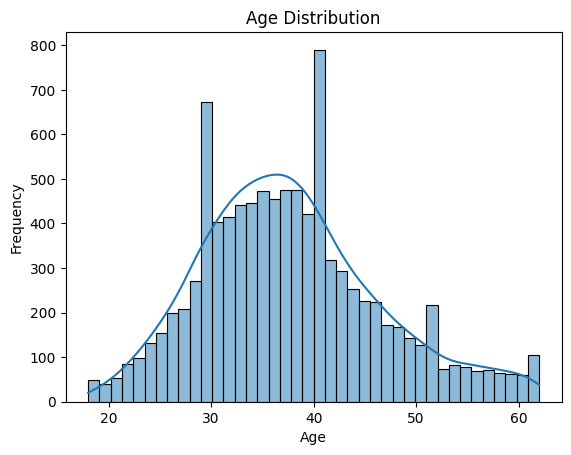

In [17]:
sns.histplot(df['age'], bins=40, kde=True)
plt.title("Age Distribution")
plt.xlabel("Age")
plt.ylabel("Frequency")
plt.show()

 This histogram shows the distribution of ages among the bank customers. 

Key points to note:
- The x-axis represents the age of the customers.
- The y-axis represents the frequency of customers within each age bin.
- The plot includes a Kernel Density Estimate (KDE) line, which provides a smoothed estimate of the distribution.

From the plot, we can observe the following:
- The age distribution appears to be roughly normal, with most customers falling within a certain age range.
- There are peaks in the distribution, indicating the most common ages among the customers.
- The KDE line helps to visualize the overall shape of the age distribution more smoothly.

This plot helps in understanding the age demographics of the bank's customer base.

In [33]:
gender_counts = df['gender'].value_counts().reset_index()
gender_counts.columns = ['gender', 'count']

fig = make_subplots(rows=1, cols=2, 
                    subplot_titles=("Gender Count (Bar Chart)", "Gender Distribution (Pie Chart)"),
                    specs=[[{"type": "bar"}, {"type": "pie"}]])

bar_chart = px.bar(gender_counts, x='gender', y='count', 
                   color='gender', labels={'gender': 'Gender', 'count': 'Count'})

for trace in bar_chart.data:
    fig.add_trace(trace, row=1, col=1)
    
pie_chart = px.pie(gender_counts, values='count', names='gender', 
                   hole=0.3, color_discrete_sequence=px.colors.qualitative.Set2)

for trace in pie_chart.data:
    trace.showlegend = False 
    fig.add_trace(trace, row=1, col=2)

fig.update_layout(title_text="Gender Count and Distribution")
fig.show()
    
    

In [34]:
df['country'].unique()

array(['France', 'Spain', 'Germany'], dtype=object)

In [37]:
fig = px.bar(
    df,
    x='country',
    color='gender',
    facet_col='churn',  
    title="Churn Distribution by Country and Gender",
    labels={'country': 'Country', 'count': 'Count', 'churn': 'Churn'},
    barmode='group',                 
    opacity=1.0                       
)
fig.update_traces(marker_line_width=0)
fig.update_layout(
    template=None,
    title_x=0.5,
    height=600,
    width=1000
)

fig.show()


In [38]:
churn_counts = df['churn'].value_counts().reset_index()
churn_counts.columns = ['churn', 'count']

fig = px.bar(churn_counts, x='churn', y='count', 
             color='churn',
             labels={'churn': 'Churn', 'count': 'Count'}, 
             title="Churn Count")

fig.show()

In [39]:
fig = px.histogram(
    df, 
    x='credit_score', 
    color='gender', 
    nbins=50, 
    title="Credit Score Distribution by Gender",
    labels={'credit_score': 'Credit Score', 'count': 'Frequency'},
    marginal="box", 
)

fig.update_layout(
    xaxis_title="Credit Score",
    yaxis_title="Frequency",
    bargap=0.1
)

fig.show()

In [21]:
age_bins = [0, 30, 40, 50, 60, 100]
age_labels = ["<30", "30-40", "40-50", "50-60", "60+"]
df['age_group'] = pd.cut(
    df['age'], 
    bins=age_bins, 
    labels=age_labels, 
    include_lowest=True,
    ordered=True
)
df['age_group'] = df['age_group'].cat.reorder_categories(age_labels, ordered=True)
fig = px.violin(
    df,
    x='age_group',
    y='credit_score',
    color='age_group', 
    box=True,          
    points='all',       
    title="Credit Score Distribution Across Age Groups",
    labels={'age_group': 'Age Group', 'credit_score': 'Credit Score'}
)

fig.update_layout(
    xaxis_title="Age Group",
    yaxis_title="Credit Score",
    bargap=0.1
)

fig.show()

In [22]:
# Calculate the correlation matrix
correlation_matrix = df.corr(numeric_only=True)

# Create a heatmap using Plotly
fig = px.imshow(correlation_matrix, 
                labels={'color': 'Correlation'}, 
                x=correlation_matrix.columns, 
                y=correlation_matrix.columns,
                color_continuous_scale="Viridis",
                title="Correlation Matrix Heatmap",
                width=900,  # Increase width
                height=800,text_auto=True)

fig.show()

### Correlation Matrix Analysis

The correlation matrix heatmap provides insights into the relationships between different numerical features in the dataset. Here are some key observations:

- **Age and Churn**: There is a positive correlation (0.285) between age and churn, indicating that older customers are more likely to churn.
- **Balance and Churn**: There is a positive correlation (0.119) between balance and churn, suggesting that customers with higher balances are more likely to churn.
- **Active Member and Churn**: There is a negative correlation (-0.156) between being an active member and churn, indicating that active members are less likely to churn.
- **Products Number and Balance**: There is a negative correlation (-0.304) between the number of products and balance, suggesting that customers with more products tend to have lower balances.
- **Credit Score and Churn**: There is a slight negative correlation (-0.027) between credit score and churn, indicating that customers with higher credit scores are slightly less likely to churn.

These correlations help in understanding the factors that influence customer churn and can be useful for building predictive models.

## Appliying Machine Learings models

In [23]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import confusion_matrix, roc_curve, f1_score, accuracy_score, roc_auc_score

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC

In [24]:
features = ['credit_score', 'credit_card', 'products_number', 'active_member', 'age', 'tenure', 'balance', 'estimated_salary', 'gender', 'country']
target = 'churn'


In [25]:
X = df[features]
y = df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [26]:
# Define columns
num_cols = ['credit_score', 'credit_card', 'products_number', 'active_member', 'age', 'tenure', 'balance', 'estimated_salary']
cat_cols = ['gender', 'country']

# Preprocessing steps
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_cols),
    ('cat', OneHotEncoder(), cat_cols)
])

In [27]:
models = {
    'Logistic Regression': LogisticRegression(),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'XGBoost': XGBClassifier( eval_metric='logloss', random_state=42),
    'Support Vector Machine': SVC(probability=True, random_state=42)
}

evaluation_results = {}
print("----- Machine Learning Models Evaluation -----")
for name, model in models.items():
    pipe = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', model)])
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    
    evaluation_results[name] = {
        'accuracy': accuracy,
        'f1_score': f1,
        'confusion_matrix': cm
    }
    print(f"{name} - Accuracy: {accuracy:.4f}, F1 Score: {f1:.4f}")
    print(f"Confusion Matrix:\n{cm}\n")
    
    if hasattr(pipe.named_steps['classifier'], "predict_proba"):
        y_proba = pipe.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        roc_auc = roc_auc_score(y_test, y_proba)
        evaluation_results[name]['roc'] = {'fpr': fpr, 'tpr': tpr, 'roc_auc': roc_auc}
    else:
        evaluation_results[name]['roc'] = None
        print(f"{name} does not support predict_proba, skipping ROC curve calculation.\n")

----- Machine Learning Models Evaluation -----
Logistic Regression - Accuracy: 0.8234, F1 Score: 0.3964
Confusion Matrix:
[[1465   59]
 [ 279  111]]

Decision Tree - Accuracy: 0.7962, F1 Score: 0.4974
Confusion Matrix:
[[1331  193]
 [ 197  193]]

Random Forest - Accuracy: 0.8610, F1 Score: 0.5696
Confusion Matrix:
[[1472   52]
 [ 214  176]]

Gradient Boosting - Accuracy: 0.8631, F1 Score: 0.5761
Confusion Matrix:
[[1474   50]
 [ 212  178]]

XGBoost - Accuracy: 0.8412, F1 Score: 0.5490
Confusion Matrix:
[[1425   99]
 [ 205  185]]

Support Vector Machine - Accuracy: 0.8511, F1 Score: 0.5061
Confusion Matrix:
[[1483   41]
 [ 244  146]]



**Ensemble Methods Excel:**                     
Both Random Forest and Gradient Boosting outperform simpler models by delivering higher accuracy and F1 scores, suggesting that ensemble methods better capture the complex patterns in churn prediction.

**F1 Score Importance:**                                  
Given the imbalanced nature of churn data, the F1 score is a critical metric. It provides a balanced measure of precision and recall, crucial for minimizing misclassification costs in business decisions.

**Confusion Matrix Analysis:**                               
    The confusion matrices highlight a trade-off:                              

    - Models like SVM reduce false positives at the cost of increasing false negatives.
    - Ensemble methods, while performing well overall, still have room for improvement in reducing false negatives.

In [28]:
def plot_confusion_matrix(cm, title):
    """Plot a colorful confusion matrix using Plotly."""
    fig = go.Figure(data=go.Heatmap(
        z=cm,
        x=['Predicted 0', 'Predicted 1'],
        y=['Actual 0', 'Actual 1'],
        colorscale='Rainbow',
        text=cm,
        texttemplate="%{text}",
        hoverinfo="x+y+z"
    ))
    fig.update_layout(
        title=title,
        xaxis_title="Predicted Label",
        yaxis_title="Actual Label",
        template="plotly_white"
    )
    fig.show()

def plot_roc_curve(fpr, tpr, roc_auc, title):
    """Plot a colorful ROC curve using Plotly."""
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=fpr, y=tpr, mode='lines', name='ROC Curve', line=dict(color='orange', width=2)))
    fig.add_trace(go.Scatter(x=[0, 1], y=[0, 1], mode='lines', name='Random Guess', line=dict(color='green', dash='dash')))
    fig.update_layout(
        title=f"{title} - ROC Curve (AUC = {roc_auc:.4f})",
        xaxis_title="False Positive Rate",
        yaxis_title="True Positive Rate",
        template="plotly_white"
    )
    fig.show()

In [29]:
for name, metrics in evaluation_results.items():
    # Plot confusion matrix
    plot_confusion_matrix(metrics['confusion_matrix'], f"{name} - Confusion Matrix")
    
    # Plot ROC curve if available
    if metrics['roc'] is not None:
        roc = metrics['roc']
        plot_roc_curve(roc['fpr'], roc['tpr'], roc['roc_auc'], name)


In [30]:
rf = RandomForestClassifier(random_state=42)
pipeline_rf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', rf)
])

In [31]:
param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [None, 10, 20],
    'classifier__min_samples_split': [2, 5],
    'classifier__class_weight': [None, 'balanced']
}

In [32]:
from sklearn.model_selection import GridSearchCV


In [33]:
grid_search = GridSearchCV(pipeline_rf, param_grid, scoring='f1', cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)
print("Best parameters:", grid_search.best_params_)
print("Best cross-validated F1 Score:", grid_search.best_score_)

Best parameters: {'classifier__class_weight': 'balanced', 'classifier__max_depth': 10, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 200}
Best cross-validated F1 Score: 0.6037039680648107


In [34]:
best_model = grid_search.best_estimator_
y_probs = best_model.predict_proba(X_test)[:, 1]
thresholds = np.arange(0.1, 0.9, 0.01)
f1_scores_threshold = [f1_score(y_test, (y_probs > t).astype(int)) for t in thresholds]
optimal_threshold = thresholds[np.argmax(f1_scores_threshold)]
print("Optimal threshold for maximum F1 score:", optimal_threshold)
print("F1 Score at optimal threshold:", np.max(f1_scores_threshold))

Optimal threshold for maximum F1 score: 0.48999999999999977
F1 Score at optimal threshold: 0.6048192771084338


In [35]:
def plot_threshold_vs_f1(thresholds, f1_scores):
    """Plot F1 Score vs Classification Threshold using Plotly."""
    fig = go.Figure(data=go.Scatter(
        x=thresholds,
        y=f1_scores,
        mode='lines+markers',
        marker=dict(color=f1_scores, colorscale='rainbow', size=10),
        line=dict(color='blue', width=2)
    ))
    fig.update_layout(
        title="F1 Score vs Classification Threshold",
        xaxis_title="Threshold",
        yaxis_title="F1 Score",
        template="plotly_white"
    )
    fig.show()

In [36]:

thresholds = np.arange(0.1, 0.9, 0.01)
plot_threshold_vs_f1(thresholds, f1_scores_threshold)

In [37]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [38]:
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

In [39]:
input_dim = X_train_transformed.shape[1]
model = Sequential([
    Dense(64, activation='relu', input_dim=input_dim),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

d:\Learning\Projects for portfolio\Project-1 (Bank Customer Churn)\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



In [40]:
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(X_train_transformed, y_train, 
                    validation_split=0.2, 
                    epochs=100, 
                    batch_size=32, 
                    callbacks=[early_stop],
                    verbose=1)

Epoch 1/100
192/192 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6637 - loss: 0.6133 - val_accuracy: 0.7858 - val_loss: 0.4569
Epoch 2/100
192/192 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8111 - loss: 0.4610 - val_accuracy: 0.7910 - val_loss: 0.4412
Epoch 3/100
192/192 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8190 - loss: 0.4300 - val_accuracy: 0.8073 - val_loss: 0.4311
Epoch 4/100
192/192 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8280 - loss: 0.4194 - val_accuracy: 0.8145 - val_loss: 0.4250
Epoch 5/100
192/192 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8438 - loss: 0.4075 - val_accuracy: 0.8191 - val_loss: 0.4178
Epoch 6/100
192/192 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8346 - loss: 0.4125 - val_accuracy: 0.8230 - val_loss: 0.4129
Epoch 7/100
192/192 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8430 - loss: 0.3979 - val_accuracy: 0.8256 - val_loss: 0.4074
Epoch 8/100
192/192 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8428 - loss: 0.3927 - val_accu

In [41]:
loss, accuracy = model.evaluate(X_test_transformed, y_test, verbose=0)
y_pred_prob = model.predict(X_test_transformed)
y_pred = (y_pred_prob > 0.5).astype(int)

print("Deep Learning Model - Accuracy: {:.4f}".format(accuracy))
print("Deep Learning Model - Loss: {:.4f}".format(loss))
f1 = f1_score(y_test, y_pred)
print("Deep Learning Model - F1 Score: {:.4f}".format(f1))

60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Deep Learning Model - Accuracy: 0.8605
Deep Learning Model - Loss: 0.3467
Deep Learning Model - F1 Score: 0.5513


In [42]:
# Compute the confusion matrix
cm_dl = confusion_matrix(y_test, y_pred)

# Compute ROC metrics
fpr_dl, tpr_dl, _ = roc_curve(y_test, y_pred_prob)
roc_auc_dl = roc_auc_score(y_test, y_pred_prob)

In [43]:
plot_confusion_matrix(cm_dl, "Deep Learning Model - Confusion Matrix")
plot_roc_curve(fpr_dl, tpr_dl, roc_auc_dl, "Deep Learning Model")

In [44]:
epochs = list(range(1, len(history.history['loss']) + 1))

# Loss Plot
fig_loss = go.Figure()
fig_loss.add_trace(go.Scatter(x=epochs, y=history.history['loss'],
                              mode='lines+markers',
                              name='Train Loss',
                              line=dict(color='blue')))
fig_loss.add_trace(go.Scatter(x=epochs, y=history.history['val_loss'],
                              mode='lines+markers',
                              name='Validation Loss',
                              line=dict(color='red', dash='dash')))
fig_loss.update_layout(title='Model Loss over Epochs',
                       xaxis_title='Epoch',
                       yaxis_title='Loss',
                       template='plotly_white')
fig_loss.show()

# Accuracy Plot
fig_acc = go.Figure()
fig_acc.add_trace(go.Scatter(x=epochs, y=history.history['accuracy'],
                             mode='lines+markers',
                             name='Train Accuracy',
                             line=dict(color='green')))
fig_acc.add_trace(go.Scatter(x=epochs, y=history.history['val_accuracy'],
                             mode='lines+markers',
                             name='Validation Accuracy',
                             line=dict(color='orange', dash='dash')))
fig_acc.update_layout(title='Model Accuracy over Epochs',
                      xaxis_title='Epoch',
                      yaxis_title='Accuracy',
                      template='plotly_white')
fig_acc.show()